## Softmax regression (AKA multiclass regression)
Task: determine whether a scale is balanced 'B', right-weighted 'R', or left-weighted 'L'

Data: From http://archive.ics.uci.edu/ml/datasets/balance+scale. Format is [class, left weight, left distance, right weight, right distance]

In [1]:
%matplotlib inline

from __future__ import division, print_function

import numpy as np
import scipy.stats as stats
from collections import Counter

### Gradient Descent
This class handles the definition of the cost function, the computation of the gradient of the cost function, training, and evaluation. The cost function used here is cross entropy with L2 regularization, defined as $J(\theta) = -\frac{1}{N}\sum_{i}^{N}\sum_{c}^{C} c_{x_i} log(P(c_{x_i} = c~|~x_i; \theta)) + \frac{\lambda}{2}\sum_{c}^{C}\sum_{f}^{F} w_{cf}^2$ where $N$ is the set of training examples, $C$ is the set of target classes, and $F$ is the number of features. $c_{x_i}$ is the predicted class for training example $x_i$. The gradient for this cost function is $\nabla_{\theta_c} J(\theta) = -\sum_{i}^N x_i \times (c_{x_i} - P(c_{x_i} = c~|~x_i; \theta))$. The likelihood of the predicted label given the data $\textbf{x}$ and parameters $\theta$ is computed using softmax, i.e. $P(c_{x_i} = c~|~x_i; \theta) = \frac{exp(\theta_c^{\top} x_i)}{\sum_{c'}^C exp(\theta_{c'}^{\top} x_i)}$. 

In [2]:
class GradientDescentTrainer(object):
    def __init__(self, train_x, train_y, l2=1, eta=0.1):
        self.x = train_x
        self.y = train_y
        self.w = stats.truncnorm.rvs(0, 0.1, size=(self.y.shape[1], self.x.shape[1]))
        self.l2 = l2   # L2 regularization parameter
        self.eta = eta  # Step size
        self.cost_log = np.empty([NUM_EPOCHS])
        self.accuracy_log = np.empty([NUM_EPOCHS])

    def print_params(self):
        print("Gradient descent optimization of cross-entropy cost function")
        print("  with L2 regularization.")
        print("L2: {0}".format(self.l2))
        print("eta: {0}".format(self.eta))

    def evaluate(self, test_x, refs):
        probs = self.softmax(xs=test_x)
        correct = np.argmax(probs, axis=0) == np.argmax(refs, axis=1)
        accuracy = 100 * np.sum(correct) / len(refs)
        return accuracy

    def train(self, num_iter=5):
        print("Training for {0} iterations".format(num_iter))
        print_every = int(round(num_iter**(0.75), -1))
        for i in xrange(num_iter):
            probs = self.softmax()
            cost = self.compute_cost(probs)
            self.cost_log[i] = cost
            train_accuracy = self.evaluate(self.x, self.y)
            self.accuracy_log[i] = train_accuracy
            if i % print_every == 0:
                print("Cost at epoch {0}: {1}".format(i, cost))
            gradient = self.compute_gradient(probs)
            self.update_weights(gradient)
        probs = self.softmax()
        cost = self.compute_cost(probs)
        print("Final cost: {0}".format(cost))

    def softmax(self, xs=None):
        if xs is not None:
            x = xs 
        else:
            x = self.x
        scores = np.dot(x, self.w.T) # Numerator
        probs = np.exp(scores).T / np.sum(np.exp(scores), axis=1)
        return probs

    def compute_cost(self, probs):
        """
        Cross-Entropy cost function.
        """
        norm = -1/self.x.shape[0]
        reg = (self.l2 / 2) * np.sum(self.w * self.w)
        cost = norm * np.sum(self.y * np.log(probs.T)) + reg
        return cost

    def compute_gradient(self, probs): 
        gradient = np.zeros([self.y.shape[1], self.x.shape[1]])
        for y in xrange(self.y.shape[1]):
            norm = -1/self.x.shape[0]
            reg = self.l2 * self.w[y]
            grad_y = norm * np.sum((self.y.T[y] - probs[y]) * self.x.T, axis=1) + reg
            gradient[y] = grad_y
        return gradient

    def update_weights(self, gradient):
        self.w = self.w - self.eta * gradient

#### Feature extraction and preparation functions
Assumes the train and test files are CSV files of the format: label,feature1,feature2,...featureN

In [3]:
def features_from_file(infile, split_train=False):
    features = []
    targets = []
    with open(infile, 'r') as inF:
        for line in inF:
            line = line.split(',')
            targets.append(line[0])
            features.append([float(f) for f in line[1:]])
    return np.array(features), np.array(targets)

def split_test_set(x, y, split=0.1, shuffle=False):
    test_size = int(len(x) * 0.1)
    if shuffle is True:
        perm = np.random.permutation(len(x))
    else:
        perm = range(len(x))    
    train_x = x[perm][test_size:]
    train_y = y[perm][test_size:]
    test_x = x[perm][:test_size]
    test_y = y[perm][:test_size]
    return (train_x, train_y, test_x, test_y)

def to_onehot(targets, classmap):
    y_t = np.zeros([len(targets), len(classmap)])
    for i,_ in enumerate(y_t):
        index = classmap[targets[i]]
        y_t[i][index] = 1
    return y_t

def from_onehot(predictions, classmap):
    inv_classmap = dict([(i,v) for (v,i) in classmap.items()])
    words = [inv_classmap[i] for i in predictions]
    return words

#### Evaluation functions
Precision and recall for each class. Precision: $\frac{\sum True~positive}{\sum Predicted~positive}$ Recall: $\frac{\sum True~positive}{\sum True~condition~positive}$. Baseline is taken as the accuracy if the system always chooses the most common class.

In [20]:
def compute_precision_recall(confusions):
    tps = [confusions[i][i] for i in range(len(confusions))]
    total_hyps = np.sum(confusions, axis=1)
    total_refs = np.sum(confusions, axis=0)
    precisions = tps / total_hyps
    recalls = tps / total_refs
    return precisions, recalls

def print_confusions(classmap, hyps, refs):
    num_classes = len(classmap)
    words = [k for k,v in sorted(classmap.items(), key=lambda x: x[1])]
    confusions = np.zeros([num_classes, num_classes], dtype='int') # hyps x refs
    for hyp, ref in zip(hyps, refs):
        ref_idx = np.argmax(ref)
        confusions[hyp][ref] += 1
    template = "{: <6}" + "{: <7}" * (num_classes+1)
    print(template.format("", *words + ["TOTAL"]))  # header
    for word, conf in zip(words, confusions):
        total = np.sum(conf)
        conf = np.append(conf, [total])
        print(template.format(word, *conf))
    total_hyps = np.sum(confusions, axis=0)
    total_hyps = np.append(total_hyps, "")
    print(template.format("TOTAL", *total_hyps))
    precisions, recalls = compute_precision_recall(confusions) 
    slots = "{:.2f} " * num_classes
    print("Precision/class: " + slots.format(*precisions))
    print("Recall/class: " + slots.format(*recalls))

def compute_baseline(train_targets, test_refs):
    # Find the most common class in the training data
    counts = Counter(train_targets)
    print(counts)
    most_common = counts.most_common(1)[0][0]
    # Always predict most common class in the training data.
    predictions = [(most_common, ref) for ref in test_refs]
    num_correct = len([pred for (pred, ref) in predictions if pred == ref])
    accuracy = 100 * num_correct / len(predictions)
    print("*** Baseline Accuracy ('{0}') *** {1:.2f} ({2}/{3})"
           .format(most_common, accuracy, num_correct, len(test_refs)))

#### Set some global variables

In [21]:
TRAINFILE = "./data/balance-shuf.data"
L2LAMBDA = 0.1
LEARNING_RATE = 1e-1
NUM_EPOCHS = 20

### Run the system
Extract and prepare the features and targets, run gradient descent, evaluate.

In [22]:
print("Reading features")
train_x, targets = features_from_file(TRAINFILE)
num_classes = len(np.unique(targets))
classmap = dict(zip(set(targets), range(num_classes)))
print(classmap)
train_x, targets, test_x, refs = split_test_set(train_x, targets, split=0.1, shuffle=False)
train_y = to_onehot(targets, classmap)
test_y = to_onehot(refs, classmap)

GD = GradientDescentTrainer(train_x, train_y, l2=L2LAMBDA, eta=LEARNING_RATE)
GD.print_params()
compute_baseline(targets, refs)
GD.train(num_iter=NUM_EPOCHS)

# Results
predictions = np.argmax(GD.softmax(xs=test_x), axis=0)
accuracy = GD.evaluate(test_x, test_y)
print("*** Test Accuracy *** {0:.2f}".format(accuracy))
print_confusions(classmap, predictions, np.argmax(test_y, axis=1))

Reading features
{'R': 1, 'B': 0, 'L': 2}
Gradient descent optimization of cross-entropy cost function
  with L2 regularization.
L2: 0.1
eta: 0.1
Counter({'L': 259, 'R': 257, 'B': 47})
*** Baseline Accuracy ('L') *** 46.77 (29/62)
Training for 20 iterations
Cost at epoch 0: 1.07132067264
Cost at epoch 10: 0.646443938843
Final cost: 0.577465168089
*** Test Accuracy *** 93.55
      B      R      L      TOTAL  
B     0      0      0      0      
R     1      31     2      34     
L     1      0      27     28     
TOTAL 2      31     29            
Precision/class: nan 0.91 0.96 
Recall/class: 0.00 1.00 0.93 


/Users/jav/Envs/sci/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


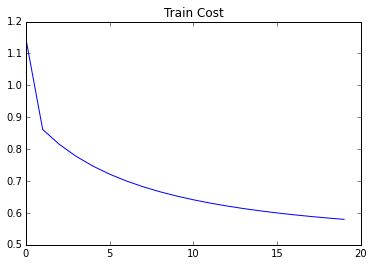

In [7]:
import matplotlib.pyplot as plt

plt.plot(GD.cost_log)
plt.title("Train Cost")
plt.show()

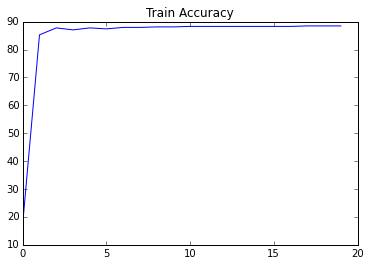

In [8]:
plt.plot(GD.accuracy_log)
plt.title("Train Accuracy")
plt.show()

## CART
We see from the confusion matrix that the classifier fails to correctly classify any balanced "B" data points. This is likely due to the distribution of classes in the test data. Since decision trees aim to split the test data as accurately as possible rather than minimize a cost function or maximize likelihood, they are more likely to take the balanced cases into account, rather than ignoring them. 

In [9]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=5, random_state=99)
clf = clf.fit(train_x, targets)

In [10]:
dt_hyps = clf.predict(test_x)
results = dt_hyps == refs
dt_accuracy = np.sum(results) / len(refs)
hyps_idx = [classmap[hyp] for hyp in dt_hyps]
refs_idx = [classmap[ref] for ref in refs]
print("*** Test Accuracy *** {0:.2f}".format(dt_accuracy))
print_confusions(classmap, hyps_idx, refs_idx)

*** Test Accuracy *** 0.81
      B      R      L      TOTAL  
B     0      3      7      10     
R     1      28     0      29     
L     1      0      22     23     
TOTAL 2      31     29            
Precision/class: 0.00 0.97 0.96 
Recall/class: 0.00 0.90 0.76 


Still not classifying balanced cases very well. Lets look at the tree.

In [11]:
with open("./graphics/dt.dot", 'w') as f:
        tree.export_graphviz(clf, out_file=f)

Then run *dot -Tpng graphics/dt.dot -o graphics/dt.png* in the terminal. From this we see something we should have expected: the questions asked are 'greater-than less-than' questions regarding each of the individual features. The tree does not take into account how the features correlate or do not correlate. For example, for a balanced scale, the sum of the first two features equals the sum of the last two features, for an unbalanced scale, the sum of the first two is greater or less than the sum of the second two. Using this intuition, let's compress our features by summing the first two and second two features. The features are: left-weight, left-distance, right-weight, right-distance.

In [12]:
def transform_features(features):
    """
    Compresses balance scale features by summing first two and last two features.
    E.g. "1,2,1,2" => "3,3"
    """
    transformed_features = np.empty([len(features), 2])
    for i,x in enumerate(features):
        left = np.sum(x[:2])
        right = np.sum(x[2:])
        transformed_features[i] = [left, right]
    return transformed_features

train_x_trans = transform_features(train_x)
test_x_trans = transform_features(test_x)

Now lets try our learning algorithms again!

In [13]:
GD_trans = GradientDescentTrainer(train_x_trans, train_y, l2=L2LAMBDA, eta=LEARNING_RATE)
GD_trans.print_params()
compute_baseline(targets, refs)
GD_trans.train(num_iter=NUM_EPOCHS)

# Results
predictions = np.argmax(GD_trans.softmax(xs=test_x_trans), axis=0)
accuracy_trans = GD_trans.evaluate(test_x_trans, test_y)
print("*** Test Accuracy *** {0:.2f}".format(accuracy_trans))
print_confusions(classmap, predictions, np.argmax(test_y, axis=1))

Gradient descent optimization of cross-entropy cost function
  with L2 regularization.
L2: 0.1
eta: 0.1
Counter({'L': 259, 'R': 257, 'B': 47})
*** Baseline Accuracy ('L') ***: 46.77 (29/62)
Training for 20 iterations
Cost at epoch 0: 1.01207315144
Cost at epoch 10: 0.72518592653
Final cost: 0.483205519856
*** Test Accuracy *** 93.55
      B      R      L      TOTAL  
B     0      0      0      0      
R     0      29     0      29     
L     2      2      29     33     
TOTAL 2      31     29            
Precision/class: nan 1.00 0.88 
Recall/class: 0.00 0.94 1.00 


/Users/jav/Envs/sci/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


Softmax regression still fails to classify the balanced instances. This is likely due to the problem noted above: There simply aren't enough balanced instances in the training data.

In [14]:
clf = tree.DecisionTreeClassifier(min_samples_split=3, random_state=99)
clf = clf.fit(train_x_trans, targets)
dt_hyps = clf.predict(test_x_trans)
results = dt_hyps == refs
dt_accuracy_trans = np.sum(results) / len(refs)
hyps_idx = [classmap[hyp] for hyp in dt_hyps]
refs_idx = [classmap[ref] for ref in refs]
print("*** Test Accuracy *** {0:.2f}".format(dt_accuracy_trans))
print_confusions(classmap, hyps_idx, refs_idx)

*** Test Accuracy *** 0.89
      B      R      L      TOTAL  
B     2      2      5      9      
R     0      29     0      29     
L     0      0      24     24     
TOTAL 2      31     29            
Precision/class: 0.22 1.00 1.00 
Recall/class: 1.00 0.94 0.83 


### Well look at that!
Let's see what is difference about this tree that makes it so much better at classifying the balanced instances.

In [15]:
with open("graphics/dt_trans.dot", 'w') as f:
        tree.export_graphviz(clf, out_file=f)

From this we see that it can now clearly ask a series of questions which figures out if the left and right side are equal. Let's visualize the separability of the transformed features, since they're 2D and easily plottable.

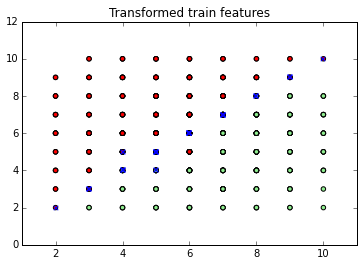

In [18]:
import matplotlib

balanced_idxs = [i for i,lab in enumerate(targets) if lab == 'B']
lab_idx = [classmap[lab]**2 for lab in targets]
colors = ['red', 'blue', 'lightgreen']
plt.scatter(train_x_trans[:,0], train_x_trans[:,1], c=lab_idx, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(train_x_trans[balanced_idxs][:,0], train_x_trans[balanced_idxs][:,1], marker='x')
plt.title("Transformed train features")
plt.show()

This shows that the classes are easily separable with the transformed features. Red: right-weighted; Green: left-weighted; Blue: balanced. **In summary**:

In [17]:
print("RAW FEATURES")
print("Softmax regression: {0:.2f}".format(accuracy))
print("Decision tree: {0:.2f}".format(dt_accuracy * 100))
print("TRANSFORMED FEATURES")
print("Softmax regression: {0:.2f}".format(accuracy_trans))
print("Decision tree: {0:.2f}".format(dt_accuracy_trans * 100))

RAW FEATURES
Softmax regression: 91.94
Decision tree: 80.65
TRANSFORMED FEATURES
Softmax regression: 93.55
Decision tree: 88.71


Transforming the features makes the problem more separable, but regression cannot take full advantage of this because of the few number of balanced examples in the training data. The DT does not match the raw accuracy of regression, even after transforming the features. It does, however, correctly classify the balanced cases, while regression does not -it simply ignores them in the training data and learns to separate 'right' and 'left' in order to minimize error. Looking at precision and recall: 

|DT   | B    | R    |  L   |
|-----|------|------|------|
|Prec | 0.22 |1.00  |1.00  |
|Rec  | 1.00 | 0.94 | 0.83 |

|Regression | B    | R    |  L   |
|-----------|------|------|------|
|Prec       | N/A  |1.00  |0.88  |
|Rec        | 0.00 |0.94  |1.00  |

This is a case in which raw accuracy is not a good indicator of system performance. For the transformed features, even though regression achieves almost 5% absolute higher accuracy than the DT, precision and recall show worse performance. 